High-performance and parallel computing for AI - Practical 5: Reduced- and mixed-precision computing
====================================================================================================

IMPORTANT
=========

For these practicals we will be using a different `conda environment`. When opening a notebook or a terminal make sure you are using the **CuPy Kernel**!!!

Question 1
----------

The `cast` function provided below takes an `LPV` array and changes its format to a new format specified by an `Option` `op`.

In [1]:
import numpy as np
from chopping import *

def cast(a, op):
    return LPV(a.array(), op)

opb = Option(True)
opb.set_format('b') # bfloat16 half precision

op = Option(True)
op.set_format('s') # single precision

a = np.array([np.pi])
aa = LPV(a, op) # single precision
ab = cast(aa, opb) # bfloat16 half precision. Note: this will round the array from single to bfloat16.

print(a[0], aa.array()[0], ab.array()[0])

3.141592653589793 3.1415927410125732 3.140625


Use the cast function to define a new function `c = mpp(a,b)` which takes two half-precision `LPV` variables `a` and `b` as inputs and computes their dot product using single precision, returning a single-precision variable `c` as output.

Let $x,a,b\in\mathbb{R}^n$ be given in numpy by `x = np.linspace(0,1,n)`, `a = np.exp(x)`, `b = np.sin(np.pi*x)**2`. Compute the dot product $a\cdot b$ using only half precision and using the `mpp` function you just wrote. By evaluating the exact dot product in double precision, compute the resulting relative rounding error for both approaches. Plot (in loglog scale) the error as a function of $n$. Are the results consistent with what we have learnt in the lectures?

Solution to Question 1
----------------------

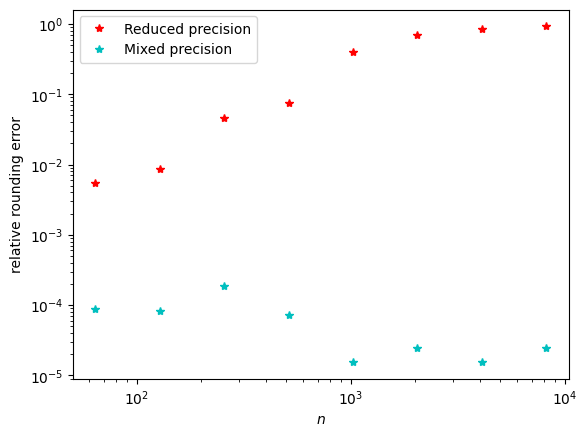

In [2]:
import matplotlib.pyplot as plt

def mpp(a,b):
    assert a.option.get_format() == b.option.get_format()
    return cast(a, op).T()@cast(b,op)

def test(n):
    x = np.linspace(0,1,n)
    a = np.exp(x)
    b = np.sin(np.pi*x)**2

    ex = a@b

    aa = LPV(a, opb)
    bb = LPV(b, opb)
    
    half = (aa.T()@bb).array()[0]
    mixed = mpp(aa,bb).array()[0]

    return abs(half-ex)/abs(ex), abs(mixed-ex)/abs(ex)

NN = 2**np.arange(6,14)
errs = np.array([list(test(n)) for n in NN])
plt.loglog(NN, errs[:,0], 'r*', label="Reduced precision")
plt.loglog(NN, errs[:,1], 'c*', label="Mixed precision")
plt.xlabel("$n$")
plt.ylabel("relative rounding error")
plt.legend()
plt.show()

# In the lectures we saw that rounding errors in dot products grow linearly in the vector size n, which is what we observe by looking at the half-precision computations.
# In mixed-precision, we instead expect O(u) accuracy as long as u_single_precision*n^2 << 1, which is what we observe in the figure.

Question 2 - Mixed-precision and overflow
-----------------------------------------

Repeat Question 5 in Practical 4, but now accumulate and store the sum using single precision (use the `cast` function). Does the computation overflow at the value computed in Question 5 of Practical 4?

For which theoretical value will the calculation overflow now? You can compute this value numerically, but, please, DO NOT try to make it overflow in practice.

Solution to Question 2
----------------------

In [3]:
oph = Option(True)
oph.set_format('h')

zero = np.array([0.])

def mpsum(a):
    n = a.size
    aa = LPV(a, oph)
    aa = cast(aa, op)
    s = LPV(zero, op)
    for i in range(n):
        s = s + aa[i]
        
    return s.array()[0]

def overflow_test(n):
    a = 2*np.arange(1,n+1)
    return mpsum(a)

# Overflow will occur when s becomes greater than xmax
# HOWEVER, now xmax is the single-precision xmax
xmax = op.get_floating_point_parameters()['xmax']
# s = n(n+1) so we need to solve a quadratic equation: n(n+1) == xmax
roots = np.roots([1, 1, -xmax])
roots = np.real(roots[np.isreal(roots)])
roots = roots[roots > 0]
n_overflow = np.ceil(min(roots))

print(overflow_test(256)) # it does not overflow

print("The computation will overflow for n =", n_overflow)

65792.0
The computation will overflow for n = 1.844674352395373e+19


Question 3 - Mixed-precision Gradient Descent
----------------------------------------------

Implement the gradient descent method in double precision for minimizing the 2D Rosenbrock function:

$$ f(x,y) = (a-x)^2 + b(y-x^2)^2 $$

where $a=\pi-3$, $b=100$. This function has a unique global minimum at the point $(a, a^2)$. For the method, set the learning rate $\gamma = 10^{-3}$, the initial condition to zero, and the maximum number of iterations to $2 \times 10^4$. 

1- Implement the scheme using only double precision (i.e., no need for the `chopping` library).

2- Implement the scheme using only bfloat16 half precision.

3- Implement the scheme in mixed precision by evaluating gradients in double precision and then casting the result to bfloat16. Use bfloat16 for storing the current iterate as well.

4- Same as 3, but evaluate gradients in single precision rather than double (use numpy for this, no need to use the `chopping` library).

In order to monitor the convergence behaviour of these methods, compute the Euclidean norm of the gradient at the current iterate every $1000$ iterations. Run all four implementations and compare their gradient norms. Can you explain this convergence behaviour based on what we have learnt in the lectures?

**Hint:** The functions provided below may be useful. It is not necessary, but feel free to modify them at will.

In [4]:
import numpy as np
from chopping import *

op = Option(True)
op.set_format("b")
op.set_round(1)
u = op.get_floating_point_parameters()["u"] # roundoff unit

# Define rosenbrock function, its gradient and Hessian, and its exact solution
a = np.pi-3
b = 100
rosenbrock = lambda x,y : (a-x)*(a-x) + b*(y - x*x)*(y - x*x)
grad = lambda x,y : [-2*a - 4*b*x*(-x*x + y) + 2*x, b*(-2*x*x + 2*y)]
hess = lambda x,y : [[2*(4*b*x*x + 2*b*(x*x - y) + 1), -4*b*x], [-4*b*x, 2*b]] # the Hessian is not really needed here
ex_sol = np.array([a, a**2])

# Computes the gradient in single precision and casts the output to double. Feel free to modify this.
def grad_single(x,y):
    return list(np.array(grad(x.astype(np.float32), y.astype(np.float32))).astype(np.float64))

# libchopping was not really designed for this so we define some utilitiy functions
# to cast to and from LPV objects
no_lpv = lambda z : (z[0].array()[0], z[1].array()[0]) if isinstance(z[0], LPV) else z
to_lpv = lambda z : (LPV(np.array([z[0]]), op), LPV(np.array([z[1]]), op)) if not isinstance(z[0], LPV) else z

Solution to Question 3
----------------------

In [5]:
import numpy as np
from chopping import *

op = Option(True)
op.set_format("b")
op.set_round(1)
u = op.get_floating_point_parameters()["u"] # roundoff unit

# Define rosenbrock function and exact solution
a = np.pi-3
b = 100
rosenbrock = lambda x,y : (a-x)*(a-x) + b*(y - x*x)*(y - x*x)
grad = lambda x,y : [-2*a - 4*b*x*(-x*x + y) + 2*x, b*(-2*x*x + 2*y)]
hess = lambda x,y : [[2*(4*b*x*x + 2*b*(x*x - y) + 1), -4*b*x], [-4*b*x, 2*b]]
ex_sol = np.array([a, a**2])

# Computes the gradient in single precision and casts the output to double. Feel free to modify this.
def grad_single(x,y):
    return list(np.array(grad(x.astype(np.float32), y.astype(np.float32))).astype(np.float64))

# libchopping was not really designed for this so we define some utilitiy functions
# to cast to and from LPV objects
no_lpv = lambda z : (z[0].array()[0], z[1].array()[0]) if isinstance(z[0], LPV) else z
to_lpv = lambda z : (LPV(np.array([z[0]]), op), LPV(np.array([z[1]]), op)) if not isinstance(z[0], LPV) else z

def exact_gd(z, gamma=1e-3):
    g = np.array(grad(*z))
    z = np.array(z)
    return z - gamma*g

def gd_update(z, mixed_precision=False, single_precision_gradients=False):
    if mixed_precision:
        # if mixed_precision, then the input z is not LPV so whatever we compute with that
        # will be in double precision
        if not single_precision_gradients:
            g = to_lpv(grad(*z)) # double precision evaluation of gradients + reduced-precision casting
        else:
            g = to_lpv(grad_single(*z)) # single precision evaluation of gradients + reduced-precision casting

    else:
        # if not mixed_precision, then the input z is LPV so whatever we compute with that
        # will be in reduced precision
        g = grad(*z) # reduced-precision gradient

    out = g

    if mixed_precision:
        out = no_lpv(out) # cast to double precision so that update is performed in double

    return out

def reduced_precision_gd(z, gamma = 1.0e-3, mixed_precision=False, single_precision_gradients=False):
    if not mixed_precision:
        z = to_lpv(z) # if not mixed-precision, updates are performed in reduced precision
    update = gd_update(z, mixed_precision, single_precision_gradients)
    return no_lpv([z[0] - gamma*update[0], z[1] - gamma*update[1]])

def gd(z, gamma=1.0e-3, mode=0):
    
    if   mode == 0: return reduced_precision_gd(z, gamma, mixed_precision=False)
    elif mode == 1: return reduced_precision_gd(z, gamma, mixed_precision=True, single_precision_gradients=True)
    elif mode == 2: return reduced_precision_gd(z, gamma, mixed_precision=True)
    elif mode == 3: return exact_gd(z, gamma)
    else: raise NotImplementedError

maxits = 20000
gamma = 1.0e-3

z = np.zeros((4,2))
gnorms = np.zeros((4,))

print("\n\nGRADIENT DESCENT:\n")
for i in range(1,maxits+1):
    for j in range(4):
        z[j] = gd(z[j], gamma=gamma, mode=j)
        gnorms[j] = np.linalg.norm(grad(*z[j]))
        
    if i%1000 == 0:
        print("Iteration %5d:" % i, " Gradient norm RP: %e" % gnorms[0], " Gradient norm MP (f32,b16): %e" % gnorms[1], " Gradient norm MP (f64,b16): %e" % gnorms[2], " Gradient norm exact method: %e" % gnorms[3])

distances = [np.linalg.norm(np.array(item) - ex_sol) for item in z]
print("\nDistance from global minima.\t RP: %e,\t MP (f32,b16): %e,\t MP (f64,b16): %e,\t exact: %e" % tuple(distances))



GRADIENT DESCENT:

Iteration  1000:  Gradient norm RP: 1.575406e-01  Gradient norm MP (f32,b16): 3.939141e-02  Gradient norm MP (f64,b16): 3.939141e-02  Gradient norm exact method: 3.939130e-02
Iteration  2000:  Gradient norm RP: 1.575406e-01  Gradient norm MP (f32,b16): 6.024613e-03  Gradient norm MP (f64,b16): 6.024613e-03  Gradient norm exact method: 6.024229e-03
Iteration  3000:  Gradient norm RP: 1.575406e-01  Gradient norm MP (f32,b16): 9.416232e-04  Gradient norm MP (f64,b16): 9.416087e-04  Gradient norm exact method: 9.414709e-04
Iteration  4000:  Gradient norm RP: 1.575406e-01  Gradient norm MP (f32,b16): 1.476879e-04  Gradient norm MP (f64,b16): 1.476804e-04  Gradient norm exact method: 1.476492e-04
Iteration  5000:  Gradient norm RP: 1.575406e-01  Gradient norm MP (f32,b16): 2.317602e-05  Gradient norm MP (f64,b16): 2.317413e-05  Gradient norm exact method: 2.316832e-05
Iteration  6000:  Gradient norm RP: 1.575406e-01  Gradient norm MP (f32,b16): 3.642584e-06  Gradient nor

Question 4 (Optional)
---------------------

**Note:** This question is optional, only work on this if you are done with everything and you still have time.

Repeat Question 3, but now implement Newton's method rather than gradient descent. Here you can play with the precision of three quantities: the iterate, the gradient, the Hessian (and its inverse). How do all possible precision choices affect convergence? For this question $10$ iterates is enough.

**Hint:** The Hessian inverse times the gradient can be computed by hand since the Hessian is a $2$-by-$2$ matrix:

```python
    # computes H^{-1}g. Feel free to modify it at will
    A = H[0][0]
    B = H[0][1]
    D = H[1][1]
    det = A*D - B*B
    iH = [[D/det, -B/det], [-B/det, A/det]]
    out = [iH[0][0]*g[0] + iH[0][1]*g[1], iH[1][0]*g[0] + iH[1][1]*g[1]]
```

Solution to Question 4
----------------------

In [6]:
import numpy as np
from chopping import *

# NOTE: This is not a complete solution as it does not try all possible precision combinations. However, it is easy enough to modify this to do so.

op = Option(True)
op.set_format("b")
op.set_round(1)
u = op.get_floating_point_parameters()["u"] # roundoff unit

# Define rosenbrock function and exact solution
a = np.pi-3
b = 100
rosenbrock = lambda x,y : (a-x)*(a-x) + b*(y - x*x)*(y - x*x)
grad = lambda x,y : [-2*a - 4*b*x*(-x*x + y) + 2*x, b*(-2*x*x + 2*y)]
hess = lambda x,y : [[2*(4*b*x*x + 2*b*(x*x - y) + 1), -4*b*x], [-4*b*x, 2*b]]
ex_sol = np.array([a, a**2])

# Computes the gradient in single precision and casts the output to double. Feel free to modify this.
def grad_single(x,y):
    return list(np.array(grad(x.astype(np.float32), y.astype(np.float32))).astype(np.float64))

# libchopping was not really designed for this so we define some utilitiy functions
# to cast to and from LPV objects
no_lpv = lambda z : (z[0].array()[0], z[1].array()[0]) if isinstance(z[0], LPV) else z
to_lpv = lambda z : (LPV(np.array([z[0]]), op), LPV(np.array([z[1]]), op)) if not isinstance(z[0], LPV) else z

def newton_update(z, mixed_precision=False):
    if mixed_precision:
        # if mixed_precision, then the input z is not LPV so whatever we compute with that
        # will be in double precision
        g = to_lpv(grad(*z)) # double precision evaluation of gradients + reduced-precision casting
        H = hess(*to_lpv(z)) # reduced-precision hessians
    else:
        # if not mixed_precision, then the input z is LPV so whatever we compute with that
        # will be in reduced precision
        g = grad(*z) # reduced-precision gradient
        H = hess(*z) # reduced-precision hessian

    # compute H^{-1}g by hand since it is easier here
    A = H[0][0]
    B = H[0][1]
    D = H[1][1]
    det = A*D - B*B
    iH = [[D/det, -B/det], [-B/det, A/det]]
    out = [iH[0][0]*g[0] + iH[0][1]*g[1], iH[1][0]*g[0] + iH[1][1]*g[1]]

    if mixed_precision:
        out = no_lpv(out) # cast to double precision so that update is performed in double

    return out

def reduced_precision_newton(z, mixed_precision=False):
    if not mixed_precision:
        z = to_lpv(z) # if not mixed-precision, updates are performed in reduced precision
    update = newton_update(z, mixed_precision)
    return no_lpv([z[0] - update[0], z[1] - update[1]])

# provided for comparison
def exact_newton(z):
    g = np.array(grad(*z))
    H = np.array(hess(*z))
    z = np.array(z)
    return z - np.linalg.solve(H,g)


maxits = 10
z = np.zeros((2,))
zm = np.zeros((2,))
zex = np.zeros((2,))

for i in range(1,maxits+1):
    z = reduced_precision_newton(z, mixed_precision=False)
    zm = reduced_precision_newton(zm, mixed_precision=True)
    zex = exact_newton(zex)
    gnorm = np.linalg.norm(grad(*z))
    gnormm = np.linalg.norm(grad(*zm))
    gnormex = np.linalg.norm(grad(*zex))
    print("Iteration %5d:" % i, " Gradient norm RP: %e" % gnorm, " Gradient norm MP: %e" % gnormm, " Gradient norm exact method: %e" % gnormex)
    
print("Distance from global minima.\t RP: %e,\t MP: %e,\t exact: %e" % (np.linalg.norm(np.array(z)-ex_sol), np.linalg.norm(np.array(zm)-ex_sol), np.linalg.norm(np.array(zex)-ex_sol)))

Iteration     1:  Gradient norm RP: 4.167921e+00  Gradient norm MP: 4.167921e+00  Gradient norm exact method: 4.167372e+00
Iteration     2:  Gradient norm RP: 4.420182e-02  Gradient norm MP: 4.420182e-02  Gradient norm exact method: 0.000000e+00
Iteration     3:  Gradient norm RP: 6.546672e-03  Gradient norm MP: 2.038136e-04  Gradient norm exact method: 0.000000e+00
Iteration     4:  Gradient norm RP: 6.546672e-03  Gradient norm MP: 2.239137e-05  Gradient norm exact method: 0.000000e+00
Iteration     5:  Gradient norm RP: 6.546672e-03  Gradient norm MP: 2.345981e-06  Gradient norm exact method: 0.000000e+00
Iteration     6:  Gradient norm RP: 6.546672e-03  Gradient norm MP: 2.144184e-07  Gradient norm exact method: 0.000000e+00
Iteration     7:  Gradient norm RP: 6.546672e-03  Gradient norm MP: 1.892255e-08  Gradient norm exact method: 0.000000e+00
Iteration     8:  Gradient norm RP: 6.546672e-03  Gradient norm MP: 1.635559e-09  Gradient norm exact method: 0.000000e+00
Iteration     9:

Question 5 - Scaling
--------------------

In this problem we will investigate the use of mixed-precision scaling techniques in a simplified setting. Consider the following optimization problem:

$$ \min_x f(x),\quad\text{where}\quad f(x) = e^{x^2} - 1. $$

This problem is strongly convex and has a unique global minimum at $x=0$, therefore gradient descent will converge to the global minimum in exact arithmetic and as the number of iterations approach infinity.

Consider the following gradient descent code:

In [7]:
import numpy as np
from chopping import *

op = Option(True)
op.set_format('h') # fp16 half precision

f = lambda x : np.exp(x**2) - 1
grad = lambda x : 2*x*np.exp(x**2)

def gd0(x, gamma=1e-5, double_precision=False):    
    
    g = grad(x)
    
    if not double_precision:
        g = chop(g, op) # rounds the gradient to fp16 half precision (it stays a Python scalar, this example does not use LPV)
    
    return x - gamma*g

x = 3.1
gamma = 1e-5
max_its = 100000
for i in range(max_its+1):
    if i%10000 == 0 or i <= 5:
        print("Iteration %5d:" % i, " Gradient norm: %e" % abs(grad(x)))

    x = gd0(x, gamma=gamma, double_precision=True)

Iteration     0:  Gradient norm: 9.246165e+04
Iteration     1:  Gradient norm: 4.940542e+02
Iteration     2:  Gradient norm: 4.824614e+02
Iteration     3:  Gradient norm: 4.714230e+02
Iteration     4:  Gradient norm: 4.608996e+02
Iteration     5:  Gradient norm: 4.508556e+02
Iteration 10000:  Gradient norm: 3.157494e+00
Iteration 20000:  Gradient norm: 1.664137e+00
Iteration 30000:  Gradient norm: 1.112368e+00
Iteration 40000:  Gradient norm: 8.137534e-01
Iteration 50000:  Gradient norm: 6.226381e-01
Iteration 60000:  Gradient norm: 4.885887e-01
Iteration 70000:  Gradient norm: 3.892610e-01
Iteration 80000:  Gradient norm: 3.130816e-01
Iteration 90000:  Gradient norm: 2.533453e-01
Iteration 100000:  Gradient norm: 2.058187e-01


Read the code and understand what it does, then change the `double_precision` flag to `False` and observer that the method blows up.

This happens because the function gradient is very large at the initial condition and causes an overflow in fp16 half precision.

By only changing either the `grad` function or by modifying the computed gradient before or after `chop` is called, try to make gradient descent converge in half-precision by preventing an overflow. You have different options (try them all, they are quick):

1- **Gradient clipping.** Set the gradient to the maximum value in the half-precision range before it is rounded.

2- **Gradient scaling.** Divide the gradient by a scalar $s$ in high precision before rounding and then multiply `gamma` by $s$ before the update. Note that gradient scaling works a bit differently in practice, but this gives you an idea.

3- **Autocasting.** Only for this one, do not apply the function `chop` if the computed gradient is beyond `xmax`, the largest number representable in float16 half precision.

4- **Initialisation.** Change the initial guess. Note that this is much trickier in AI, but there is lots of literature on good initialization techniques.

5- **SignGD.** This is a crazy one: replace the gradient with its sign before the chop. Here you can set the learning rate `gamma` to be $10$ times larger.

6- **Change gradient.** This is somehow related to the previous one. Replace the gradient function with another function that has smaller magnitude, but has the same sign as the gradient. Note: this is just for fun, it will work here, but it is something that is impossible to do (or at least very very hard) for more complicated problems.

Solution to Question 5
----------------------

In [8]:
f = lambda x : np.exp(x**2) - 1
grad = lambda x : 2*x*np.exp(x**2)

xmax = op.get_floating_point_parameters()['xmax']

def gd_clipping(x, gamma=1e-5, double_precision=False):    
    
    g = grad(x)

    g = g if abs(g) < xmax else xmax*np.sign(x)
    
    if not double_precision:
        g = chop(g, op) # rounds the gradient to fp16 half precision (it stays a Python scalar, this example does not use LPV)
    
    return x - gamma*g

def gd_scaling(x, gamma=1e-5, double_precision=False):    

    scale = 2**10
    g = grad(x)/scale
    
    if not double_precision:
        g = chop(g, op) # rounds the gradient to fp16 half precision (it stays a Python scalar, this example does not use LPV)
    
    return x - (gamma*scale)*g

def gd_autocasting(x, gamma=1e-5, double_precision=False):
    
    g = grad(x)
    
    if not double_precision and abs(g) < xmax:
        g = chop(g, op) # rounds the gradient to fp16 half precision (it stays a Python scalar, this example does not use LPV)
    
    return x - gamma*g

def signGD(x, gamma=1e-5, double_precision=False):
    
    g = grad(x)

    g = np.sign(g)
    
    if not double_precision:
        g = chop(g, op) # rounds the gradient to fp16 half precision (it stays a Python scalar, this example does not use LPV)
    
    return x - gamma*g

new_grad = lambda x : x*np.exp(2*x)

def gradient_change(x, gamma=1e-5, double_precision=False):
    
    g = new_grad(x)
    
    if not double_precision:
        g = chop(g, op) # rounds the gradient to fp16 half precision (it stays a Python scalar, this example does not use LPV)
    
    return x - gamma*g

for gd in [gd_clipping, gd_scaling, gd_autocasting, gd0, signGD, gradient_change]:

    method_name = gd.__name__
    if method_name == 'gd0': method_name = 'initial_guess'
    
    print("\nMethod: " + method_name, "\n")
    
    x = 3.1 if method_name != 'initial_guess' else 1.0
    gamma = 1e-5 if method_name != 'signGD' else 1e-4
    max_its = 100000
    for i in range(max_its+1):
        if i%100000 == 0 or i <= 5:
            print("Iteration %5d:" % i, " Gradient norm: %e" % abs(grad(x)))

        x = gd(x, gamma=gamma, double_precision=False)


Method: gd_clipping 

Iteration     0:  Gradient norm: 9.246165e+04
Iteration     1:  Gradient norm: 1.929479e+03
Iteration     2:  Gradient norm: 1.742594e+03
Iteration     3:  Gradient norm: 1.590277e+03
Iteration     4:  Gradient norm: 1.463681e+03
Iteration     5:  Gradient norm: 1.356602e+03
Iteration 100000:  Gradient norm: 2.059437e-01

Method: gd_scaling 

Iteration     0:  Gradient norm: 9.246165e+04
Iteration     1:  Gradient norm: 4.936184e+02
Iteration     2:  Gradient norm: 4.820494e+02
Iteration     3:  Gradient norm: 4.710316e+02
Iteration     4:  Gradient norm: 4.605269e+02
Iteration     5:  Gradient norm: 4.505003e+02
Iteration 100000:  Gradient norm: 2.058185e-01

Method: gd_autocasting 

Iteration     0:  Gradient norm: 9.246165e+04
Iteration     1:  Gradient norm: 4.940542e+02
Iteration     2:  Gradient norm: 4.824626e+02
Iteration     3:  Gradient norm: 4.714233e+02
Iteration     4:  Gradient norm: 4.608983e+02
Iteration     5:  Gradient norm: 4.508521e+02
Iterati